<a href="https://colab.research.google.com/github/KumudaBG/DeepLearning-Assignment4/blob/main/MNIST_classifier_using_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import sys,numpy as np
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

#Load Data

In [3]:
(xtrain,ytrain),(xtest,ytest)=mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
print("training set x shape: ",xtrain.shape)
print("test set x shape: ",xtest.shape)

training set x shape:  (60000, 28, 28)
test set x shape:  (10000, 28, 28)


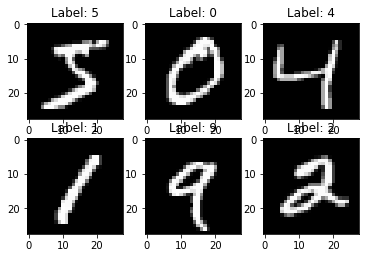

In [5]:
plt.figure(figsize=[6,6])
for i in range(6):
  plt.subplot(3,3,i+1)
  plt.title("Label: %i"%ytrain[i])
  plt.imshow(xtrain[i].reshape([28,28]),cmap='gray')

The xtrain,xtest are two dimensional, converting them into one dimension data

In [6]:
images=xtrain.reshape(len(xtrain),28*28)/255
test_images=xtest.reshape(len(xtest),28*28)/255

In [7]:
print("training set x shape",images.shape)
print("test set x shape",test_images.shape)

training set x shape (60000, 784)
test set x shape (10000, 784)


In [8]:
print("training set y shape: ",ytrain.shape)
print("test set y shape: ",ytest.shape)

training set y shape:  (60000,)
test set y shape:  (10000,)


In [9]:
one_hot_labels=np.zeros((len(ytrain),10))

In [10]:
for i,l in enumerate(ytrain):
  one_hot_labels[i][l]=1

labels=one_hot_labels

In [11]:
testlabels=np.zeros((len(ytest),10))

for i,l in enumerate(ytest):
  testlabels[i][l]=1

In [12]:
np.random.seed(1)

#Activation function ReLU and its derivative 

In [13]:
def relu(x):
    return (x>=0)*x

In [14]:
def relu2deriv(output):
    return output>=0

#Defining Learning Rate, Batch Size 

In [15]:
alpha=0.001 #Defining learning rate
iterations=10 #Number of iterations
hidden_size1=100 #Hidden Layer 1 size
pixels=784 #28*28 converted to one dimension feature set
num_labels=10 #Labels
hidden_size2=100 #Hidden Layer 2 size
batchsize=3 #batch size for mini batch gradient descent

#Weight initialisation

In [16]:
weights_01=0.2*np.random.random((pixels,hidden_size1))-0.1
weights_12=0.2*np.random.random((hidden_size1,hidden_size2))-0.1
weights_23=0.2*np.random.random((hidden_size2,num_labels))-0.1

#Data Augmentation

In [17]:
xtrain_augmented = xtrain
ytrain_augmented = ytrain

In [18]:
xtrain_augmented = xtrain_augmented.reshape(-1,28,28,1)

In [19]:
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1, 
        horizontal_flip=False,  
        vertical_flip=False) 
datagen.fit(xtrain_augmented)

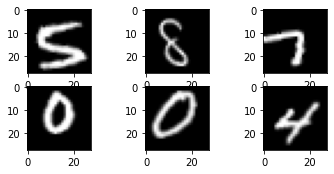

In [20]:
for X_batch, y_batch in datagen.flow(xtrain_augmented, ytrain_augmented, batch_size=6):
	# create a grid of 3x3 images
	for i in range(6):
		plt.subplot(3,3,i+1)
		plt.imshow(X_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
	# show the plot
	plt.show()
	break

In [21]:
def data_augmentation(x_train,y_train,augment_size=5000): 
        image_generator = ImageDataGenerator(
            rotation_range=10,
            zoom_range = 0.05, 
            width_shift_range=0.05,
            height_shift_range=0.05,
            horizontal_flip=False,
            vertical_flip=False, 
            data_format="channels_last",
            zca_whitening=True)
        image_generator.fit(x_train, augment=True)       
        train_size=len(x_train)
        randidx = np.random.randint(train_size, size=augment_size)
        x_augmented = x_train[randidx].copy()
        y_augmented = y_train[randidx].copy()
        x_augmented = image_generator.flow(x_augmented, np.zeros(augment_size),
                                    batch_size=augment_size, shuffle=False).next()[0]        
        x_train = np.concatenate((x_train, x_augmented))
        y_train = np.concatenate((y_train, y_augmented))
        train_size = x_train.shape[0]
        return x_train, y_train

In [22]:
xtrain = xtrain.reshape((xtrain.shape[0], 28, 28,1))

xtrain,ytrain=data_augmentation(xtrain,ytrain)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


#Model Training -Using DropOut

In [23]:

#Iteratively carry out the forward and back propagation
for j in range(iterations):
  error,correct_cnt=(0.0,0)

  #Carry out mini batch gradient descent. Calculate the batches and iterate over it.
  for i in range(int(len(images)/batchsize)):

    #Calculate the batch start and end value to fetch to those images.
    batchstart,batchend=((i*batchsize),((i+1)*batchsize))

    #Select the first layer as the images from the batch size.
    layer_0=images[batchstart:batchend]

    #Create the first layer by multiplying the imput layer with the weights and passing it through Relu activation function. 
    layer_1=relu(np.dot(layer_0,weights_01))

    #Drop few neurons from the layers to avoid overfitting the model
    dropout_mask=np.random.randint(2,size=layer_1.shape)
    layer_1*=dropout_mask*2

    #Create the second layer by multiplying layer 1 with its input layer's weights
    layer_2=np.dot(layer_1,weights_12)

    #Create the third layer by multiplying layer 2 with its input layer's weights
    layer_3=np.dot(layer_2,weights_23)

    #Calculate the error by finding the difference between training final layer data and the calculated final layer data
    error+=np.sum((labels[batchstart:batchend]-layer_3)**2)

    #Conduct the backpropagation
    for k in range(batchsize):

      correct_cnt+=int(np.argmax(layer_3[k:k+1])==np.argmax(labels[batchstart+k:batchstart+k+1]))

      #Calculate the third layer delta by taking the difference of expected and actual output
      layer_3_delta=(labels[batchstart:batchend]-layer_3)/batchsize

      #Calculate the second layer delta by multiplying the third layer delta and weights from second layer
      layer_2_delta=layer_3_delta.dot(weights_23.T)

      #Calculate the second layer delta by multiplying the third layer delta and weights from second layer and its Relu derivative. 
      #As Relu is applied on this layer.
      layer_1_delta=layer_2_delta.dot(weights_12.T)*relu2deriv(layer_1)

      #Update the weight values
      weights_23+=alpha*layer_2.T.dot(layer_3_delta)
      weights_12+=alpha*layer_1.T.dot(layer_2_delta)
      weights_01+=alpha*layer_0.T.dot(layer_1_delta)


  #Print the ratio of error and correct values for every iteration
  print("I"+str(j))
  print("Error "+str(error/float(len(images)))[0:5],"Correct "+str(correct_cnt/float(len(images))))

I0
Error 0.549 Correct 0.6961
I1
Error 0.453 Correct 0.7793666666666667
I2
Error 0.432 Correct 0.7939666666666667
I3
Error 0.424 Correct 0.7987833333333333
I4
Error 0.419 Correct 0.8035666666666667
I5
Error 0.414 Correct 0.8067333333333333
I6
Error 0.413 Correct 0.8073166666666667
I7
Error 0.413 Correct 0.80685
I8
Error 0.413 Correct 0.8093666666666667
I9
Error 0.413 Correct 0.8082166666666667


#Model Testing

In [26]:
#store predicted values in numpy array
predictedlabels= np.zeros((len(testlabels), 10))
if(j%10==0 or j==iterations-1):
  error,correct_cnt=(0.0,0)

  #For the test images as the input, apply the calculated weight values during the training phase to find the labels of the images.
  for i in range(len(test_images)):

    layer_0=test_images[i:i+1]
    layer_1=relu(np.dot(layer_0,weights_01))
    layer_2=np.dot(layer_1,weights_12)
    layer_3=np.dot(layer_2,weights_23)
    predictedlabels[i]=layer_3
    #Calculate the difference between the expected and actual values. Calculate the error and correct values predicted.
    error+=np.sum((testlabels[i:i+1]-layer_3)**2)
    correct_cnt+=int(np.argmax(layer_3)==np.argmax(testlabels[i:i+1]))
    

print("shape",testlabels.shape)
print("shape",layer_3.shape)
error=str(error/float(len(test_images)))[0:5]
correct=str(correct_cnt/float(len(test_images)))
print("Error "+error)
print("Correct "+correct)

shape (10000, 10)
shape (1, 10)
Error 0.314
Correct 0.8632


##Accuracy of the model

In [27]:
accuracy=float(correct)/(float(correct)+float(error))
accuracy

0.7332653754672103

##Change the dimension of predicted label ndarray to 1 dimension for subjecting to confusion matrix

In [37]:
predictedlabels[0]

array([-0.03633764, -0.02089278,  0.02039132,  0.11215687, -0.01944423,
       -0.0393286 , -0.01887385,  1.05515536, -0.0835215 , -0.01714439])

In [46]:
predicted_labels = np.argmax(predictedlabels, axis=1)#pick the index containing maximum value in the entire row
print(predicted_labels[0])
type(predicted_labels)

7


numpy.ndarray

##Change the dimension of test label ndarray to 1 dimension for subjecting to confusion matrix

In [41]:
testlabels[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [47]:
test_labels = np.argmax(testlabels, axis=1)#pick the index containing maximum value in the entire row
print(test_labels[0])
type(test_labels)

7


numpy.ndarray

#Visualization using confusion matrix

In [29]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

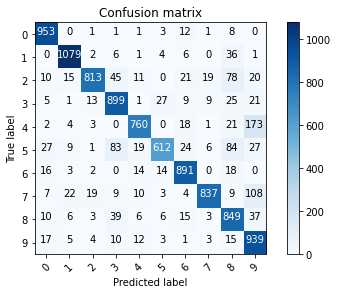

In [48]:
confusion_matrix = confusion_matrix(test_labels, predicted_labels) 
plot_confusion_matrix(confusion_matrix, classes = range(10))